# Cats and Dogs Toy Example

This notebook will train, quantize, and synthesis the Cats and Dogs example. We want to use this example to show that a high test set accuracy does not guarantee a high accuracy on the board.

### Import the necessary modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import distiller.apputils as apputils

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from cats_and_dogs import *

mod = importlib.import_module("cat-dog_net")

import ai8x
%matplotlib inline

## Define Helper Functions

In [2]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

## Create and Load the Datasets

In [3]:
args = Args(act_mode_8bit=False)
data_path = "../Datasets/cats_and_dogs/"

train_set, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)

{'dogs': 0, 'cats': 1}
{'dogs': 0, 'cats': 1}


## Visualize a batch of training data

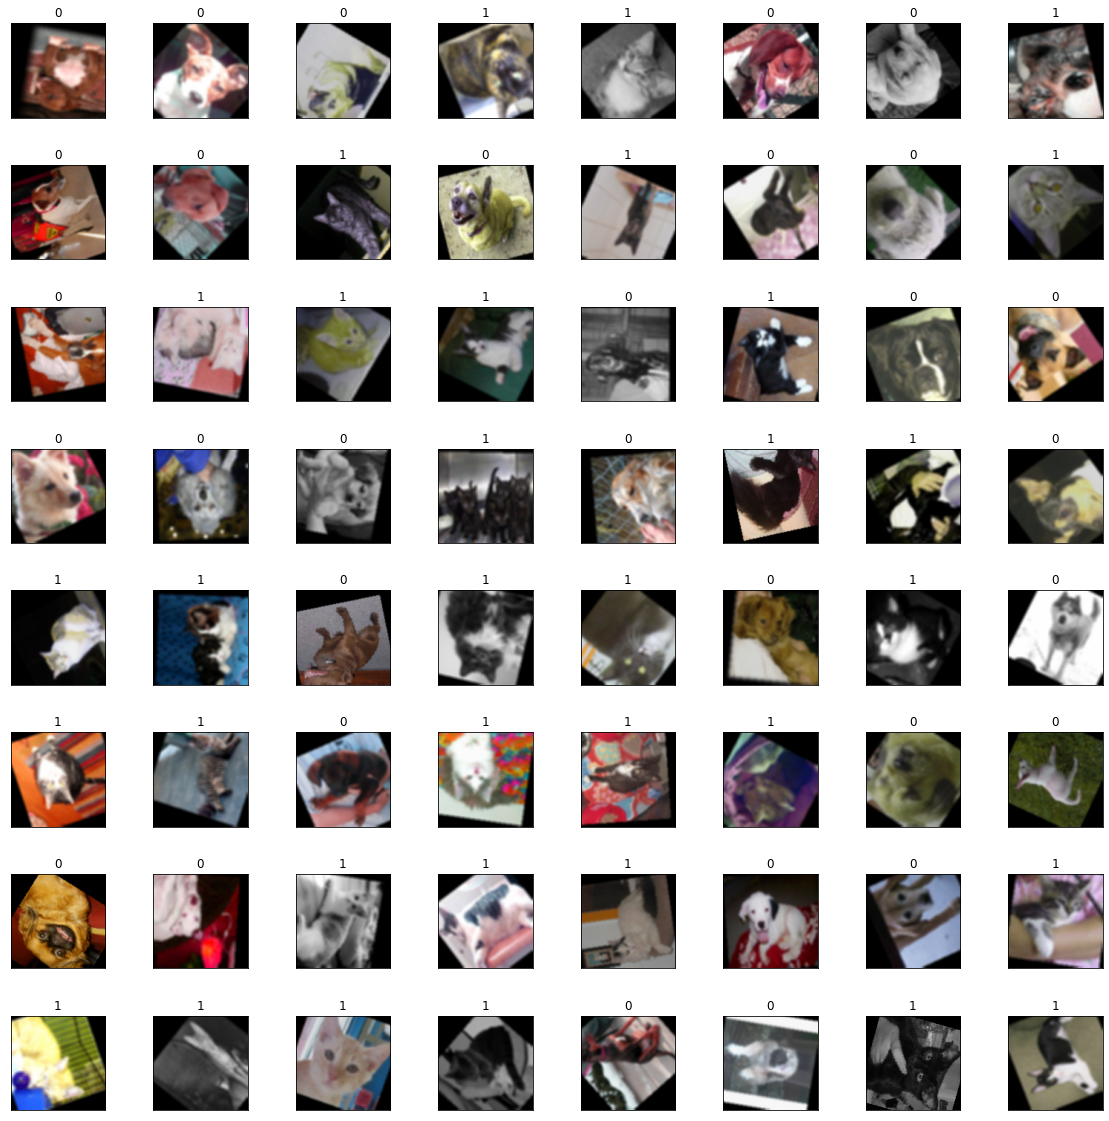

In [4]:
train_set.visualize_batch()

## Create the data loaders

In [5]:
batch_size = 64
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True)

## Set up the device, cuda or cpu

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Set up the model for training

In [7]:
ai8x.set_device(device=85, simulate=False, round_avg=False)

model = mod.CatsAndDogsClassifier()
        
model = model.to(device)

print(f'Number of Model Params: {count_params(model)}')

Configuring device: MAX78000, simulate=False.
Number of Model Params: 34818


## Set up the training parameters

In [8]:
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.001)
ms_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30], gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

qat_policy = {'start_epoch':10,
              'weight_bits':8}

## Run the trianing loop

In [13]:
best_acc = 0
best_qat_acc = 0
for epoch in range(0, num_epochs):
    if epoch > 0 and epoch == qat_policy['start_epoch']:
        print('QAT is starting!')
        # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
        ai8x.fuse_bn_layers(model)

        # Switch model from unquantized to quantized for QAT
        ai8x.initiate_qat(model, qat_policy)

        # Model is re-transferred to GPU in case parameters were added
        model.to(device)
    running_loss = []
    train_start = time.time()
    model.train()
    for idx, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.type(torch.long).to(device)
        optimizer.zero_grad()
        
        model_out = model(image)
        
        loss = criterion(model_out, label)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())

    mean_loss = np.mean(running_loss)
    train_end = time.time()
    print("Epoch: {}/{}\t LR: {}\t Train Loss: {:.4f}\t Dur: {:.2f} sec.".format(epoch+1, num_epochs, ms_lr_scheduler.get_lr(), mean_loss, (train_end-train_start)))
    
    model.eval()
    acc = 0.
    acc_weight = 0
    with torch.no_grad():
        for image, label in test_dataloader:
            image = image.to(device)
            label = label.type(torch.long).to(device)
            model_out = model(image)
            label_out = torch.argmax(model_out, dim=1)
            
            tp = torch.sum(label_out == label)
            acc_batch = (tp / label_out.numel()).detach().item()
            acc += label_out.shape[0] * acc_batch
            acc_weight += label_out.shape[0]
            
        total_acc = 100 * (acc / acc_weight)
        if epoch == qat_policy['start_epoch']: best_acc = 0
        if total_acc > best_acc:
            best_acc = total_acc
            checkpoint_extras = {'current_top1': best_acc,
                                 'best_top1': best_acc,
                                 'best_epoch': epoch}
            model_name = 'cats_and_dogs_'
            model_prefix = f'{model_name}' if epoch < qat_policy['start_epoch'] else (f'qat_{model_name}')
            apputils.save_checkpoint(epoch, model_name, model, optimizer=optimizer,
                                     scheduler=None, extras=checkpoint_extras,
                                     is_best=True, name=model_prefix,
                                     dir='.')
            print(f'Best model saved with accuracy: {best_acc:.2f}%')
            
        print('\t\t Test Acc: {:.2f}'.format(total_acc))
    ms_lr_scheduler.step()

Epoch: 1/50	 LR: [0.001]	 Train Loss: 0.6240	 Dur: 79.44 sec.


NameError: name 'im_size' is not defined